Analysis of influence of single-neuron excitability changes on network population activity.

In [49]:
%matplotlib inline
%autosave 60
from copy import deepcopy
import os
import sys

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import stats

from aux import Generic, GenericFlexible, load, save
from ntwk import LIFNtwk
from disp import raster, set_font_size

from _1A import *

Autosaving every 60 seconds


# Settings

In [50]:
SEED = 0
MAX_SEED = 2**32 - 1

N = 100
E_L_1 = -0.05

Q = 0.1  # cxn density
GAMMA = 1.3141  # SF ntwk power-law coef
P_RW = 0.1  # rewiring prob for SW ntwk

W_E_UP = 0.01  # cxn weight for upstream excitatory drive
FRQ_UP = 429  # frq of upstream excitatory drive

W_E_RCR_SF = 0.00735  # rcr cxn weight for SF ntwk
W_E_RCR_SW = 0.00773  # rcr cxn weight for SW ntwk
W_E_RCR_ER = 0.00762  # rcr cxn weight for ER ntwk

T_M = 0.05  # membrane time constant (s)
E_L = -0.068  # leak/resting potential (V)
V_TH = -0.036  # spike threshold (V)
V_RESET = -0.068  # reset potential (V)
T_R = 0.002  # refractory period

E_E = 0  # exc syn. reversal potential (V)
T_E = 0.002  # exc. syn. time constant

STM_OFF = 2  # time to turn stim off
DUR = 2.5  # full smln duration
DT = 0.0005  # smln time step

# for analysis
T_START = 0.5  # start time for measuring firing rate
T_END = 2  # end time for measuring firing rate
T_BIN_SIZE = 0.05  # bin size for measuring spike correlations

# for looping over network sizes
NS = [100, 200, 500]
GAMMAS = [1.3141, 1.2240, 1.14379]
W_E_RCRS_SF = [0.00735, 0.00392, 0.00154]
W_E_RCRS_SW = [0.00773, 0.00384, 0.00153]
W_E_RCRS_ER = [0.00762, 0.00382, 0.00153]

N_TRIALS = 50  # number of random ntwk instantiations for statistics

# for parameter identification
PID_GAMMAS = np.linspace(0.5, 3, 500)[:-1]  # for identifying gamma in SF ntwk
PID_FR_N_TRIALS = 50  # for tuning firing rates

# for data memoization
DATA_FILE = '_1A.npy'


# derived grouped params for ntwk smlns

## unconnected
P_UNC = Generic(
    # ntwk
    n=N, t_m=T_M, e_l=E_L, v_th=V_TH, v_reset=V_RESET, t_r=T_R,
    e_e=E_E, t_e=T_E, w_e_up=W_E_UP,
    
    # input & smln
    frq_up=FRQ_UP, stm_off=STM_OFF,
    dt=DT, dur=DUR, seed=SEED,

    # analysis
    t_start=T_START, t_end=T_END, t_bin_size=T_BIN_SIZE)

## scale-free
P_SF = Generic(
    # ntwk
    gamma=GAMMA, n=N, t_m=T_M, e_l=E_L, v_th=V_TH, v_reset=V_RESET, t_r=T_R,
    e_e=E_E, t_e=T_E, w_e_rcr=W_E_RCR_SF, w_e_up=W_E_UP,
    
    # input & slmn
    frq_up=FRQ_UP, stm_off=STM_OFF, dt=DT, dur=DUR, seed=5,

    # analysis
    t_start=T_START, t_end=T_END, t_bin_size=T_BIN_SIZE)

## small-world
P_SW = Generic(
    # ntwk
    k=int(np.round(Q*N)), p=P_RW, n=N, t_m=T_M, e_l=E_L, v_th=V_TH, v_reset=V_RESET, t_r=T_R,
    e_e=E_E, t_e=T_E, w_e_rcr=W_E_RCR_SW, w_e_up=W_E_UP,
    
    # input & smln
    frq_up=FRQ_UP, stm_off=STM_OFF, dt=DT, dur=DUR, seed=2,

    # analysis
    t_start=T_START, t_end=T_END, t_bin_size=T_BIN_SIZE)

## erdos-renyi
P_ER = Generic(
    # ntwk
    q=Q, n=N, t_m=T_M, e_l=E_L, v_th=V_TH, v_reset=V_RESET, t_r=T_R,
    e_e=E_E, t_e=T_E, w_e_rcr=W_E_RCR_ER, w_e_up=W_E_UP,
    
    # input & smln
    frq_up=FRQ_UP, stm_off=STM_OFF, dt=DT, dur=DUR, seed=2,
    
    # analysis
    t_start=T_START, t_end=T_END, t_bin_size=T_BIN_SIZE)

# Graph parameters
Identify scale-free/small-world graph construction params.

In [ ]:
# skip (don't run automatically)
raise Exception()

## Scale-free exponent (gamma)

Intersections with Q = 0.1:

N = 100: 1.3141282565130261
N = 200: 1.223947895791583
N = 500: 1.1437875751503004


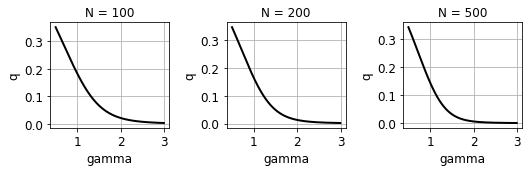

In [3]:
# skip
fig, axs = plt.subplots(1, 3, figsize=(7.5, 7.5/3), tight_layout=True)

istns = []  # for storing intersections with Q = ...
for n, ax in zip(NS, axs):

    # get mean q expected for diff gammas in SF ntwk
    qs = np.array([dctd_p_law_mean_q(n, gam) for gam in PID_GAMMAS])

    # compute intersection with Q
    idx_istn = (qs <= Q).nonzero()[0][0]
    istn = .5 * (PID_GAMMAS[idx_istn-1] + PID_GAMMAS[idx_istn])
    istns.append(istn)

    ax.plot(PID_GAMMAS, qs, color='k', lw=2)

    ax.grid()

    ax.set_xlabel('gamma')
    ax.set_ylabel('q')
    ax.set_title('N = {}'.format(n))

    set_font_size(ax, 12)
        
print('Intersections with Q = {}:\n'.format(Q))

for n, istn in zip(NS, istns):
    print('N = {}: {}'.format(n, istn))

## Check small-world cxn density

In [4]:
# skip
for n in NS:
    k = int(Q * n)
    adj = sw_adj(n, k, P_RW, SEED)
    q = adj.sum() / (n**2)
    
    print('N = {}, K = {}, Q = {}'.format(n, k, q))

N = 100, K = 10, Q = 0.1
N = 200, K = 20, Q = 0.1
N = 500, K = 50, Q = 0.1


## Check EPSP induced by excitatory cxn weight

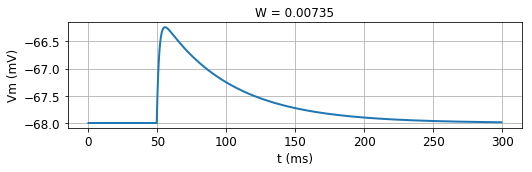

In [5]:
# skip
ntwk = LIFNtwk(
    t_m=np.array([T_M]),
    e_l=np.array([E_L]),
    v_th=np.array([V_TH]),
    v_reset=np.array([V_RESET]),
    t_r=np.array([T_R]),
    es_syn={'E': E_E},
    ts_syn={'E': T_E},
    ws_rcr={'E': np.array([[0.]])},
    ws_up={'E': np.array([[W_E_RCR_SF]])})

t = np.arange(0, 0.3, DT)
spks_up = np.zeros((len(t), 1))
spks_up[int(0.05/DT), 0] = 1

rsp = ntwk.run(spks_up=spks_up, dt=DT)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5/3), tight_layout=True)
ax.plot(1000 * t, 1000 * rsp.vs[:, 0], lw=2)
ax.grid()
ax.set_xlabel('t (ms)')
ax.set_ylabel('Vm (mV)')
ax.set_title('W = {}'.format(W_E_RCR_SF))
set_font_size(ax, 12)

# Ntwk smln params
Hand-identify ntwk smln params to yield mean firing rate of 20 Hz.

## Unconnected ntwk

In [ ]:
# skip
raise Exception()

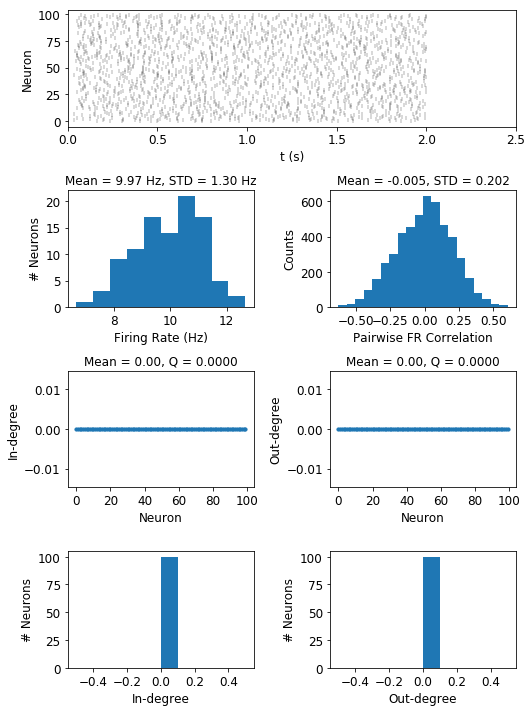

In [6]:
STORE_UNC = GenericFlexible()
rfcd(unc_ntwk, P_UNC, STORE_UNC);

## Scale-free ntwk

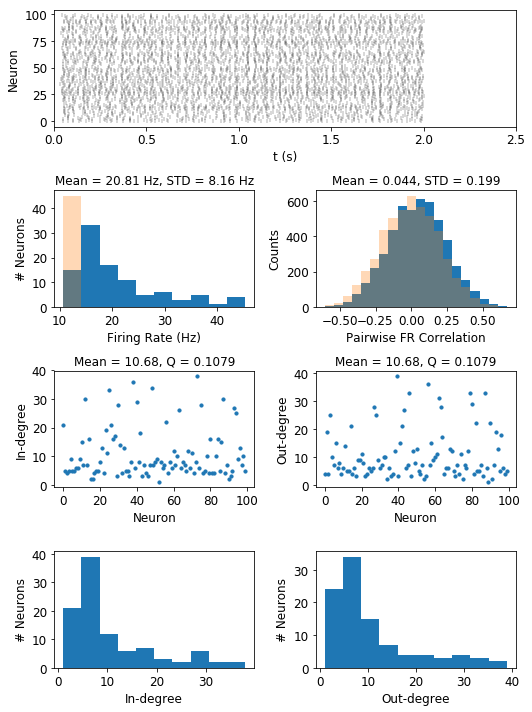

In [7]:
STORE_SF = GenericFlexible()
rfcd(sf_ntwk, P_SF, STORE_SF, STORE_UNC=STORE_UNC);

In [ ]:
raise Exception()

### Check GAMMA and W_E_RCR_SF for diff N
Ensure firing rates are approximately 20 Hz averaged over network instantiations.

In [8]:
# skip
## get dstr of mean FRs in SF ntwk averaged across instantiations
p_sf = deepcopy(P_SF)
p_sf.__dict__['n'] = NS[0]
p_sf.__dict__['gamma'] = GAMMAS[0]
p_sf.__dict__['w_e_rcr'] = W_E_RCRS_SF[0]

np.random.seed(SEED)
fr_means = []
for _ in range(PID_FR_N_TRIALS):
    sys.stdout.write('*')
    # get param set w/ new seed
    p_sf.__dict__['seed'] = np.random.randint(0, MAX_SEED)
    fr = rfcd(sf_ntwk, p_sf, STORE_SF, STORE_UNC=STORE_UNC, plot=False)
    fr_means.append(fr.mean())

print('')
print('Mean FR = {} Hz'.format(np.mean(fr_means)))
print('STD FR = {} Hz'.format(np.std(fr_means)))
print('SEM FR = {} Hz'.format(stats.sem(fr_means)))

*******************

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


*******************************
Mean FR = 20.086933333333334 Hz
STD FR = 3.00555247943979 Hz
SEM FR = 0.4293646399199699 Hz


In [9]:
# skip
## get dstr of mean FRs in SF ntwk averaged across instantiations
p_sf = deepcopy(P_SF)
p_sf.__dict__['n'] = NS[1]
p_sf.__dict__['gamma'] = GAMMAS[1]
p_sf.__dict__['w_e_rcr'] = W_E_RCRS_SF[1]

np.random.seed(SEED)
fr_means = []
for _ in range(PID_FR_N_TRIALS):
    sys.stdout.write('*')
    # get param set w/ new seed
    p_sf.__dict__['seed'] = np.random.randint(0, MAX_SEED)
    fr = rfcd(sf_ntwk, p_sf, STORE_SF, STORE_UNC=STORE_UNC, plot=False)
    fr_means.append(fr.mean())

print('')
print('Mean FR = {} Hz'.format(np.mean(fr_means)))
print('STD FR = {} Hz'.format(np.std(fr_means)))
print('SEM FR = {} Hz'.format(stats.sem(fr_means)))

***********************************************

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


***
Mean FR = 20.007 Hz
STD FR = 2.4047286980262683 Hz
SEM FR = 0.34353267114660974 Hz


In [10]:
# skip
## get dstr of mean FRs in SF ntwk averaged across instantiations
p_sf = deepcopy(P_SF)
p_sf.__dict__['n'] = NS[2]
p_sf.__dict__['gamma'] = GAMMAS[2]
p_sf.__dict__['w_e_rcr'] = W_E_RCRS_SF[2]

np.random.seed(SEED)
fr_means = []
for _ in range(PID_FR_N_TRIALS):
    sys.stdout.write('*')
    # get param set w/ new seed
    p_sf.__dict__['seed'] = np.random.randint(0, MAX_SEED)
    fr = rfcd(sf_ntwk, p_sf, STORE_SF, STORE_UNC=STORE_UNC, plot=False)
    fr_means.append(fr.mean())

print('')
print('Mean FR = {} Hz'.format(np.mean(fr_means)))
print('STD FR = {} Hz'.format(np.std(fr_means)))
print('SEM FR = {} Hz'.format(stats.sem(fr_means)))

**************************************************
Mean FR = 19.947733333333332 Hz
STD FR = 1.7360970786988459 Hz
SEM FR = 0.2480138683855494 Hz


## Small-world params

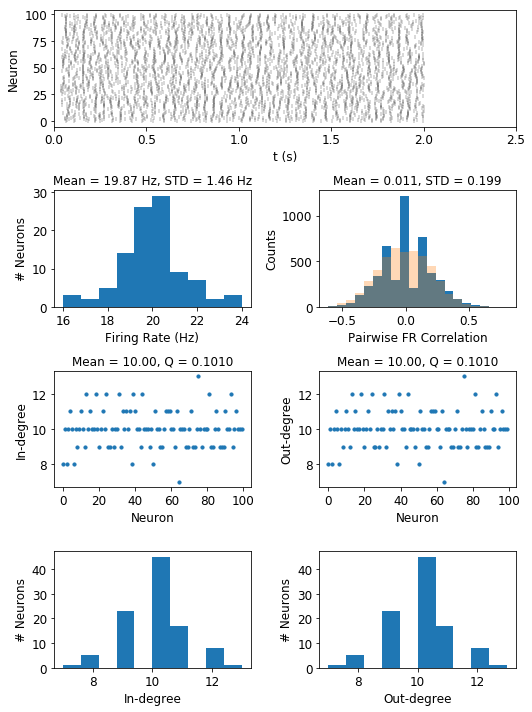

In [11]:
STORE_SW = GenericFlexible()
rfcd(sw_ntwk, P_SW, STORE_SW, STORE_UNC=STORE_UNC);

In [ ]:
raise Exception()

### Check W_E_RCR_SW for different N

In [12]:
# skip
## get dstr of mean FRs in SW ntwk averaged across instantiations
p_sw = deepcopy(P_SW)
p_sw.__dict__['n'] = NS[0]
p_sw.__dict__['k'] = int(np.round(Q*NS[0]))
p_sw.__dict__['w_e_rcr'] = W_E_RCRS_SW[0]

np.random.seed(SEED)
fr_means = []
for _ in range(PID_FR_N_TRIALS):
    sys.stdout.write('*')
    # get param set w/ new seed
    p_sw.__dict__['seed'] = np.random.randint(0, MAX_SEED)
    fr = rfcd(sw_ntwk, p_sw, STORE_SW, STORE_UNC=STORE_UNC, plot=False)
    fr_means.append(fr.mean())

print('')
print('Mean FR = {} Hz'.format(np.mean(fr_means)))
print('STD FR = {} Hz'.format(np.std(fr_means)))
print('SEM FR = {} Hz'.format(stats.sem(fr_means)))

**************************************************
Mean FR = 19.990266666666667 Hz
STD FR = 0.23345981333935095 Hz
SEM FR = 0.03335140190562156 Hz


In [13]:
# skip
## get dstr of mean FRs in SW ntwk averaged across instantiations
p_sw = deepcopy(P_SW)
p_sw.__dict__['n'] = NS[1]
p_sw.__dict__['k'] = int(np.round(Q*NS[1]))
p_sw.__dict__['w_e_rcr'] = W_E_RCRS_SW[1]

np.random.seed(SEED)
fr_means = []
for _ in range(PID_FR_N_TRIALS):
    sys.stdout.write('*')
    # get param set w/ new seed
    p_sw.__dict__['seed'] = np.random.randint(0, MAX_SEED)
    fr = rfcd(sw_ntwk, p_sw, STORE_SW, STORE_UNC=STORE_UNC, plot=False)
    fr_means.append(fr.mean())

print('')
print('Mean FR = {} Hz'.format(np.mean(fr_means)))
print('STD FR = {} Hz'.format(np.std(fr_means)))
print('SEM FR = {} Hz'.format(stats.sem(fr_means)))

**************************

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


************************
Mean FR = 20.004466666666666 Hz
STD FR = 0.14522872381943633 Hz
SEM FR = 0.020746960545633762 Hz


In [14]:
# skip
## get dstr of mean FRs in SW ntwk averaged across instantiations
p_sw = deepcopy(P_SW)
p_sw.__dict__['n'] = NS[2]
p_sw.__dict__['k'] = int(np.round(Q*NS[2]))
p_sw.__dict__['w_e_rcr'] = W_E_RCRS_SW[2]

np.random.seed(SEED)
fr_means = []
for _ in range(PID_FR_N_TRIALS):
    sys.stdout.write('*')
    # get param set w/ new seed
    p_sw.__dict__['seed'] = np.random.randint(0, MAX_SEED)
    fr = rfcd(sw_ntwk, p_sw, STORE_SW, STORE_UNC=STORE_UNC, plot=False)
    fr_means.append(fr.mean())

print('')
print('Mean FR = {} Hz'.format(np.mean(fr_means)))
print('STD FR = {} Hz'.format(np.std(fr_means)))
print('SEM FR = {} Hz'.format(stats.sem(fr_means)))

*************

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


*************************************
Mean FR = 19.95672 Hz
STD FR = 0.10177525042956166 Hz
SEM FR = 0.01453932148993738 Hz


## Erdos-Renyi params

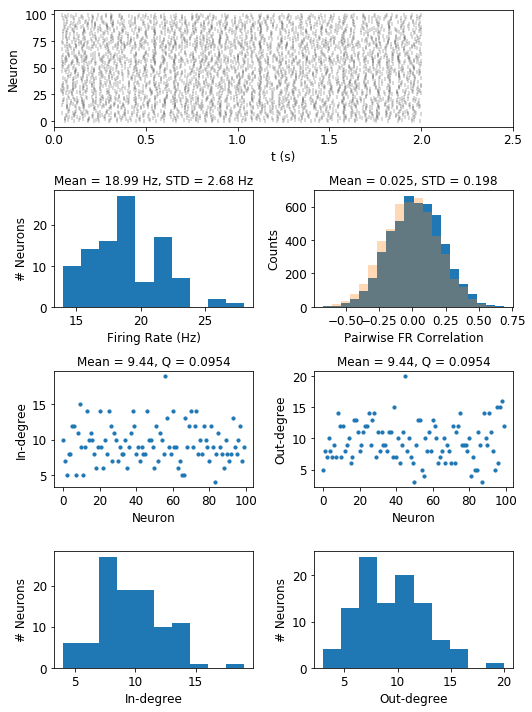

In [15]:
STORE_ER = GenericFlexible()
rfcd(er_ntwk, P_ER, STORE_ER, STORE_UNC=STORE_UNC);

In [ ]:
raise Exception()

### Check W_E_RCR_ER for different N

In [16]:
# skip
## get dstr of mean FRs in SW ntwk averaged across instantiations
p_er = deepcopy(P_ER)
p_er.__dict__['n'] = NS[0]
p_er.__dict__['w_e_rcr'] = W_E_RCRS_ER[0]

np.random.seed(SEED)
fr_means = []
for _ in range(PID_FR_N_TRIALS):
    sys.stdout.write('*')
    # get param set w/ new seed
    p_er.__dict__['seed'] = np.random.randint(0, MAX_SEED)
    fr = rfcd(er_ntwk, p_er, STORE_ER, STORE_UNC=STORE_UNC, plot=False)
    fr_means.append(fr.mean())

print('')
print('Mean FR = {} Hz'.format(np.mean(fr_means)))
print('STD FR = {} Hz'.format(np.std(fr_means)))
print('SEM FR = {} Hz'.format(stats.sem(fr_means)))

**************************************************
Mean FR = 20.040933333333335 Hz
STD FR = 0.6301943403956175 Hz
SEM FR = 0.09002776291365965 Hz


In [17]:
# skip
## get dstr of mean FRs in SW ntwk averaged across instantiations
p_er = deepcopy(P_ER)
p_er.__dict__['n'] = NS[1]
p_er.__dict__['w_e_rcr'] = W_E_RCRS_ER[1]

np.random.seed(SEED)
fr_means = []
for _ in range(PID_FR_N_TRIALS):
    sys.stdout.write('*')
    # get param set w/ new seed
    p_er.__dict__['seed'] = np.random.randint(0, MAX_SEED)
    fr = rfcd(er_ntwk, p_er, STORE_ER, STORE_UNC=STORE_UNC, plot=False)
    fr_means.append(fr.mean())

print('')
print('Mean FR = {} Hz'.format(np.mean(fr_means)))
print('STD FR = {} Hz'.format(np.std(fr_means)))
print('SEM FR = {} Hz'.format(stats.sem(fr_means)))

**********

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


****************************************
Mean FR = 19.982133333333334 Hz
STD FR = 0.3438686829461375 Hz
SEM FR = 0.049124097563733926 Hz


In [18]:
# skip
## get dstr of mean FRs in SW ntwk averaged across instantiations
p_er = deepcopy(P_ER)
p_er.__dict__['n'] = NS[2]
p_er.__dict__['w_e_rcr'] = W_E_RCRS_ER[2]

np.random.seed(SEED)
fr_means = []
for _ in range(PID_FR_N_TRIALS):
    sys.stdout.write('*')
    # get param set w/ new seed
    p_er.__dict__['seed'] = np.random.randint(0, MAX_SEED)
    fr = rfcd(er_ntwk, p_er, STORE_ER, STORE_UNC=STORE_UNC, plot=False)
    fr_means.append(fr.mean())

print('')
print('Mean FR = {} Hz'.format(np.mean(fr_means)))
print('STD FR = {} Hz'.format(np.std(fr_means)))
print('SEM FR = {} Hz'.format(stats.sem(fr_means)))

**

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


************************************************
Mean FR = 20.042373333333334 Hz
STD FR = 0.14121763566290912 Hz
SEM FR = 0.020173947951844157 Hz


# Excitabilty analysis

## Scale-free examples

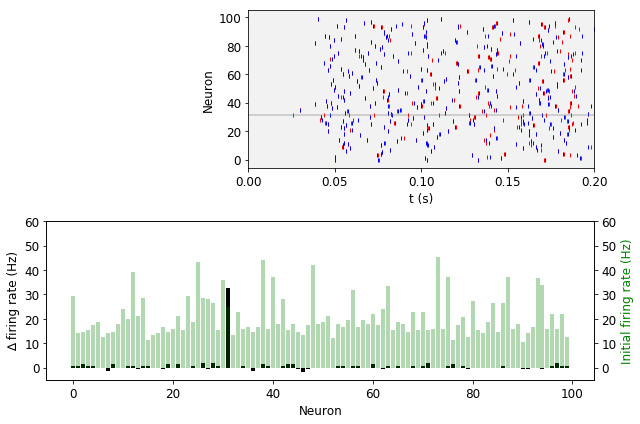

In [19]:
run_example(sf_ntwk, [31], E_L_1, P_SF, STORE=GenericFlexible());

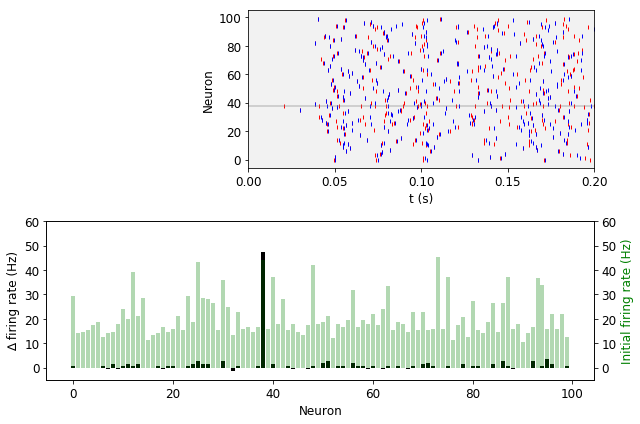

In [20]:
run_example(sf_ntwk, [38], E_L_1, P_SF, STORE=GenericFlexible());

## Small-world examples

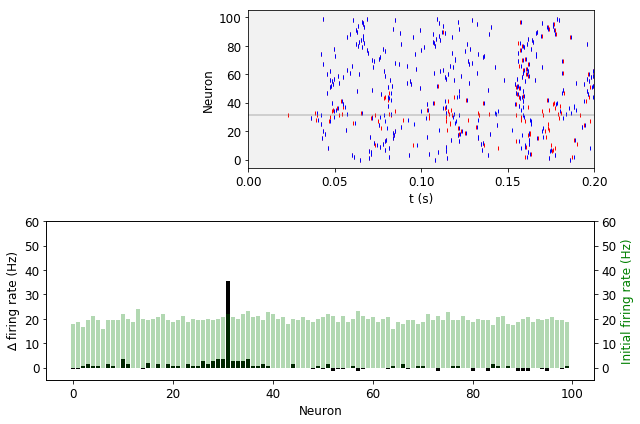

In [21]:
run_example(sw_ntwk, [31], E_L_1, P_SW, STORE=GenericFlexible());

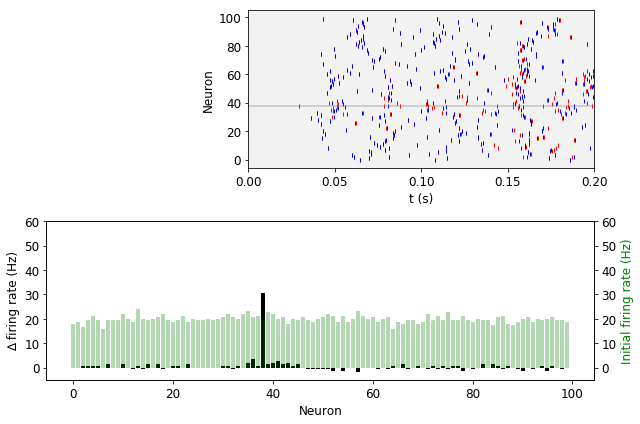

In [22]:
run_example(sw_ntwk, [38], E_L_1, P_SW, STORE=GenericFlexible());

## Erdos-Renyi examples

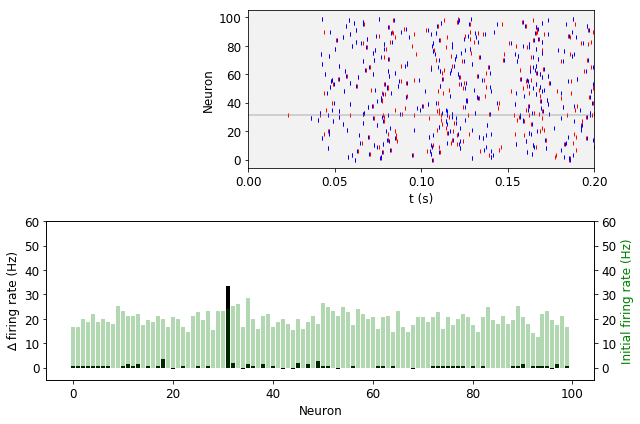

In [23]:
run_example(er_ntwk, [31], E_L_1, P_ER, STORE=GenericFlexible());

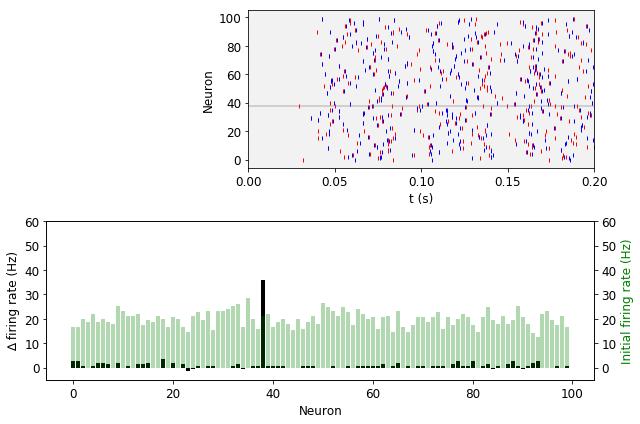

In [24]:
run_example(er_ntwk, [38], E_L_1, P_ER, STORE=GenericFlexible());

# Excitability influence distributions

# Comparing excitability influence distributions across network structures

In [51]:
xblt_ifls = {}

## Scale-free

In [52]:
xblt_ifl_sf, in_deg_sf, out_deg_sf = calc_xblt_ifl(sf_ntwk, P_SF, E_L_1)

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........

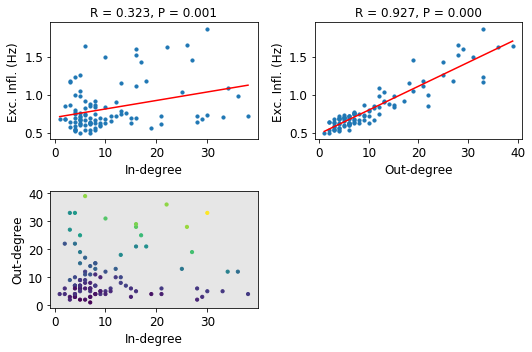

In [53]:
plot_xblt_ifl_vs_deg(xblt_ifl_sf, in_deg_sf, out_deg_sf)
xblt_ifls['sf'] = deepcopy(xblt_ifl_sf)

## Small-world

In [54]:
xblt_ifl_sw, in_deg_sw, out_deg_sw = calc_xblt_ifl(sw_ntwk, P_SW, E_L_1)

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........

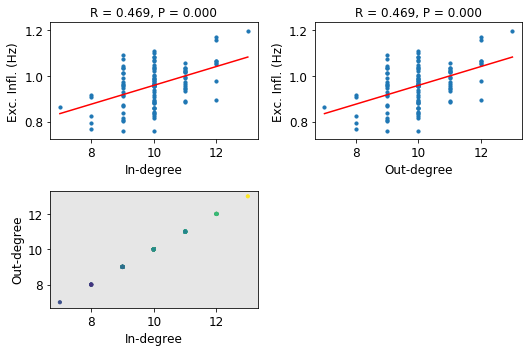

In [55]:
plot_xblt_ifl_vs_deg(xblt_ifl_sw, in_deg_sw, out_deg_sw)
xblt_ifls['sw'] = deepcopy(xblt_ifl_sw)

## Erdos-Renyi

In [56]:
xblt_ifl_er, in_deg_er, out_deg_er = calc_xblt_ifl(er_ntwk, P_ER, E_L_1)

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........

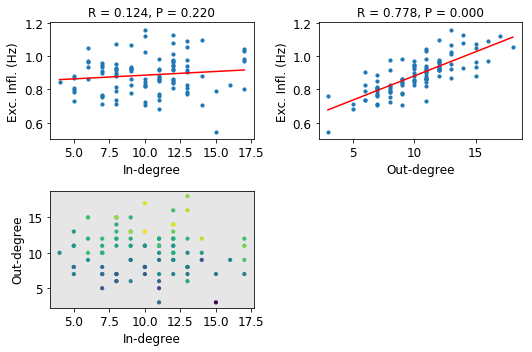

In [57]:
plot_xblt_ifl_vs_deg(xblt_ifl_er, in_deg_er, out_deg_er)
xblt_ifls['er'] = deepcopy(xblt_ifl_er)

## Compare excitability influence distributions

SF: mu = 0.82, std = 0.30
SW: mu = 0.96, std = 0.09
ER: mu = 0.89, std = 0.11


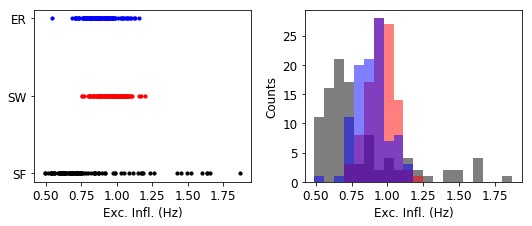

In [69]:
colors = {'sf': 'k', 'sw': 'r', 'er': 'b'}
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3.25), tight_layout=True)

axs[0].scatter(xblt_ifls['sf'], np.repeat(0, P_SF.n), c=colors['sf'], s=10)
axs[0].scatter(xblt_ifls['sw'], np.repeat(1, P_ER.n), c=colors['sw'], s=10)
axs[0].scatter(xblt_ifls['er'], np.repeat(2, P_ER.n), c=colors['er'], s=10)

axs[0].set_xlabel('Exc. Infl. (Hz)')
axs[0].set_yticks([0, 1, 2])
axs[0].set_yticklabels(['SF', 'SW', 'ER'])

bins = np.histogram(xblt_ifls['sf'], bins=20)[1]

axs[1].hist(xblt_ifls['sf'], bins, color=colors['sf'], alpha=0.5)
axs[1].hist(xblt_ifls['sw'], bins, color=colors['sw'], alpha=0.5)
axs[1].hist(xblt_ifls['er'], bins, color=colors['er'], alpha=0.5)

axs[1].set_xlabel('Exc. Infl. (Hz)')
axs[1].set_ylabel('Counts')

for ax in axs:
    set_font_size(ax, 12)
    
print('SF: mu = {0:.2f}, std = {1:.2f}'.format(
    np.mean(xblt_ifls['sf']),
    np.std(xblt_ifls['sf'])))
      
print('SW: mu = {0:.2f}, std = {1:.2f}'.format(
    np.mean(xblt_ifls['sw']),
    np.std(xblt_ifls['sw'])))
    
print('ER: mu = {0:.2f}, std = {1:.2f}'.format(
    np.mean(xblt_ifls['er']),
    np.std(xblt_ifls['er'])))

# Re-run for multiple random seeds and different N

In [59]:
# load data if already saved
data = load(os.path.join('data', DATA_FILE))

xblt_ifls_all = data['xblt_ifls_all']
in_degs_all = data['in_degs_all']
out_degs_all = data['out_degs_all']
xblt_ifl_means_all = data['xblt_ifl_means_all']
xblt_ifl_stds_all = data['xblt_ifl_stds_all']
xblt_ifl_maxs_all = data['xblt_ifl_maxs_all']
frs_0_all = data['frs_0_all']
frs_1_all = data['frs_1_all']

In [ ]:
raise Exception()

In [33]:
xblt_ifls_all = []
in_degs_all = []
out_degs_all = []

xblt_ifl_means_all = []
xblt_ifl_stds_all = []

frs_0_all = []
frs_1_all = []

for n_ctr, n in enumerate(NS):
    
    print('\nN = {}:'.format(n))

    P_SF.__dict__['n'] = n
    P_SF.__dict__['gamma'] = GAMMAS[n_ctr]
    P_SF.__dict__['w_e_rcr'] = W_E_RCRS_SF[n_ctr]
    
    P_SW.__dict__['n'] = n
    P_SW.__dict__['k'] = int(np.round(Q*n))
    P_SW.__dict__['w_e_rcr'] = W_E_RCRS_SW[n_ctr]
    
    P_ER.__dict__['n'] = n
    P_ER.__dict__['w_e_rcr'] = W_E_RCRS_ER[n_ctr]
    
    np.random.seed(SEED)

    xblt_ifls = {'sf': [], 'sw': [], 'er': []}
    in_degs = {'sf': [], 'sw': [], 'er': []}
    out_degs = {'sf': [], 'sw': [], 'er': []}
    
    xblt_ifl_means = {'sf': [], 'sw': [], 'er': []}
    xblt_ifl_stds = {'sf': [], 'sw': [], 'er': []}
    
    frs_0 = {'sf': [], 'sw': [], 'er': []}
    frs_1 = {'sf': [], 'sw': [], 'er': []}

    for ctr in range(N_TRIALS):
        
        print('Trial {}'.format(ctr + 1))

        seed = np.random.randint(0, 10000000)

        P_SF.__dict__['seed'] = seed
        P_SW.__dict__['seed'] = seed
        P_ER.__dict__['seed'] = seed

        xblt_ifl_sf, in_deg_sf, out_deg_sf, frs_0_sf, frs_1_sf = calc_xblt_ifl(
            sf_ntwk, P_SF, E_L_1, return_frs=True)
        print('')
        xblt_ifl_sw, in_deg_sw, out_deg_sw, frs_0_sw, frs_1_sw = calc_xblt_ifl(
            sw_ntwk, P_SW, E_L_1, return_frs=True)
        print('')
        xblt_ifl_er, in_deg_er, out_deg_er, frs_0_er, frs_1_er = calc_xblt_ifl(
            er_ntwk, P_ER, E_L_1, return_frs=True)

        xblt_ifls['sf'].append(xblt_ifl_sf)
        in_degs['sf'].append(in_deg_sf)
        out_degs['sf'].append(out_deg_sf)
        
        xblt_ifl_means['sf'].append(np.mean(xblt_ifl_sf))
        xblt_ifl_stds['sf'].append(np.std(xblt_ifl_sf))
        
        frs_0['sf'].append(frs_0_sf)
        frs_1['sf'].append(frs_1_sf)

        xblt_ifls['sw'].append(xblt_ifl_sw)
        in_degs['sw'].append(in_deg_sw)
        out_degs['sw'].append(out_deg_sw)
        
        xblt_ifl_means['sw'].append(np.mean(xblt_ifl_sw))
        xblt_ifl_stds['sw'].append(np.std(xblt_ifl_sw))
        
        frs_0['sw'].append(frs_0_sw)
        frs_1['sw'].append(frs_1_sw)

        xblt_ifls['er'].append(xblt_ifl_er)
        in_degs['er'].append(in_deg_er)
        out_degs['er'].append(out_deg_er)
        
        xblt_ifl_means['er'].append(np.mean(xblt_ifl_er))
        xblt_ifl_stds['er'].append(np.std(xblt_ifl_er))
                
        frs_0['er'].append(frs_0_er)
        frs_1['er'].append(frs_1_er)

        print('')
        
    xblt_ifls_all.append(deepcopy(xblt_ifls))
    in_degs_all.append(deepcopy(in_degs))
    out_degs_all.append(deepcopy(out_degs))
    
    xblt_ifl_means_all.append(xblt_ifl_means)
    xblt_ifl_stds_all.append(xblt_ifl_stds)
    
    frs_0_all.append(deepcopy(frs_0))
    frs_1_all.append(deepcopy(frs_1))


N = 100:
Trial 1
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 2
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 3
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 4
|.........|.........|.........|.........|........

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 28
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 29
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 30
|.........|.........|.........|.........|.........|.........|...

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 3
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.......

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 16
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|......

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 29
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 30
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.......

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 43
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|......

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 3
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|........

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|........

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 19
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|........

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|........

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 35
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|........

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|........

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........


### Check degree distributions

N = 100

Mean In-degree/N (SF) = 0.101372
Mean Out-degree/N (SF) = 0.101372

Mean In-degree/N (SW) = 0.1
Mean Out-degree/N (SW) = 0.1

Mean In-degree/N (ER) = 0.100626
Mean Out-degree/N (ER) = 0.100626

N = 200

Mean In-degree/N (SF) = 0.102258
Mean Out-degree/N (SF) = 0.102258

Mean In-degree/N (SW) = 0.1
Mean Out-degree/N (SW) = 0.1

Mean In-degree/N (ER) = 0.099649
Mean Out-degree/N (ER) = 0.099649

N = 500

Mean In-degree/N (SF) = 0.09868008
Mean Out-degree/N (SF) = 0.09868008

Mean In-degree/N (SW) = 0.1
Mean Out-degree/N (SW) = 0.1

Mean In-degree/N (ER) = 0.09997272
Mean Out-degree/N (ER) = 0.09997272



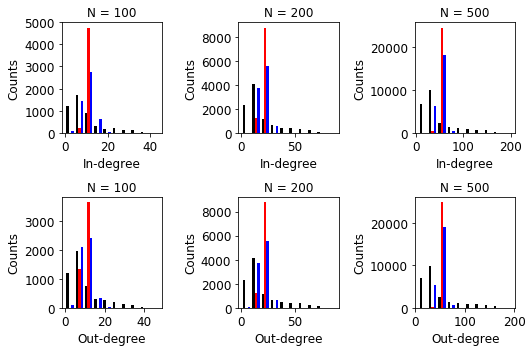

In [60]:
# plot in- and out-degree distributions for each N and ntwk type
fig, axs = plt.subplots(2, 3, figsize=(7.5, 5), tight_layout=True)
colors = {'sf': 'k', 'sw': 'r', 'er': 'b'}

for n_ctr, n in enumerate(NS):
    
    in_deg_sf = np.array(in_degs_all[n_ctr]['sf']).flatten()
    in_deg_sw = np.array(in_degs_all[n_ctr]['sw']).flatten()
    in_deg_er = np.array(in_degs_all[n_ctr]['er']).flatten()
    
    out_deg_sf = np.array(out_degs_all[n_ctr]['sf']).flatten()
    out_deg_sw = np.array(out_degs_all[n_ctr]['sw']).flatten()
    out_deg_er = np.array(out_degs_all[n_ctr]['er']).flatten()
    
    ax = axs[0, n_ctr]
    
    ax.hist(
        np.array([in_deg_sf, in_deg_sw, in_deg_er]).T, bins=10,
        color=[colors[k] for k in ['sf', 'sw', 'er']])
    
    ax.set_xlabel('In-degree')
    ax.set_ylabel('Counts')
    ax.set_title('N = {}'.format(n))
    
    
    ax = axs[1, n_ctr]
    
    ax.hist(np.array([out_deg_sf, out_deg_sw, out_deg_er]).T, bins=10,
        color=[colors[k] for k in ['sf', 'sw', 'er']])
    
    ax.set_xlabel('Out-degree')
    ax.set_ylabel('Counts')
    ax.set_title('N = {}'.format(n))
    
for ax in axs.flatten():
    set_font_size(ax, 12)
    
for n_ctr, n in enumerate(NS):
    
    in_deg_sf = np.array(in_degs_all[n_ctr]['sf']).flatten()
    in_deg_sw = np.array(in_degs_all[n_ctr]['sw']).flatten()
    in_deg_er = np.array(in_degs_all[n_ctr]['er']).flatten()
    
    out_deg_sf = np.array(out_degs_all[n_ctr]['sf']).flatten()
    out_deg_sw = np.array(out_degs_all[n_ctr]['sw']).flatten()
    out_deg_er = np.array(out_degs_all[n_ctr]['er']).flatten()
    
    print('N = {}\n'.format(n))
    print('Mean In-degree/N (SF) = {}'.format(in_deg_sf.mean()/n))
    print('Mean Out-degree/N (SF) = {}\n'.format(out_deg_sf.mean()/n))
    
    print('Mean In-degree/N (SW) = {}'.format(in_deg_sw.mean()/n))
    print('Mean Out-degree/N (SW) = {}\n'.format(out_deg_sw.mean()/n))
    
    print('Mean In-degree/N (ER) = {}'.format(in_deg_er.mean()/n))
    print('Mean Out-degree/N (ER) = {}\n'.format(out_deg_er.mean()/n))

### Check firing rate distributions

In [61]:
for n_ctr, n in enumerate(NS):

    print('N = {}'.format(n))
    
    print('FR_0_MEAN_SF = {}'.format(np.mean(frs_0_all[n_ctr]['sf'])))
    print('FR_0_MEAN_SW = {}'.format(np.mean(frs_0_all[n_ctr]['sw'])))
    print('FR_0_MEAN_ER = {}'.format(np.mean(frs_0_all[n_ctr]['er'])))

N = 100
FR_0_MEAN_SF = 19.496
FR_0_MEAN_SW = 19.982266666666664
FR_0_MEAN_ER = 20.110133333333337
N = 200
FR_0_MEAN_SF = 21.075933333333346
FR_0_MEAN_SW = 19.980400000000003
FR_0_MEAN_ER = 19.98553333333333
N = 500
FR_0_MEAN_SF = 19.74109333333336
FR_0_MEAN_SW = 19.95466666666663
FR_0_MEAN_ER = 20.005919999999993


## Plot mean excitability influence distributions

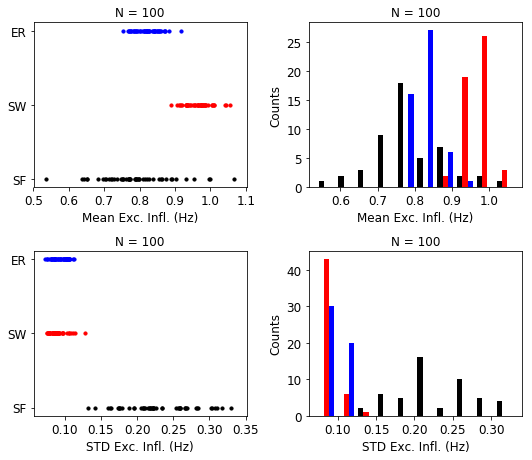

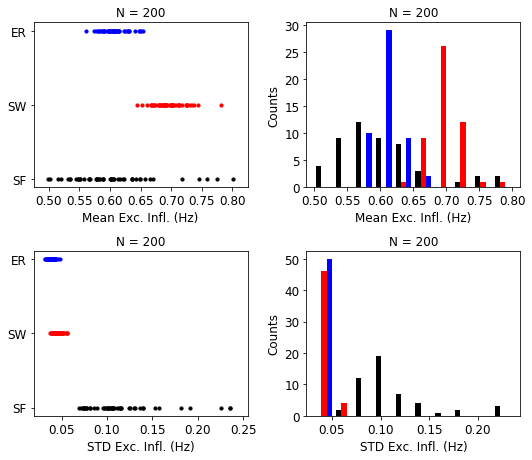

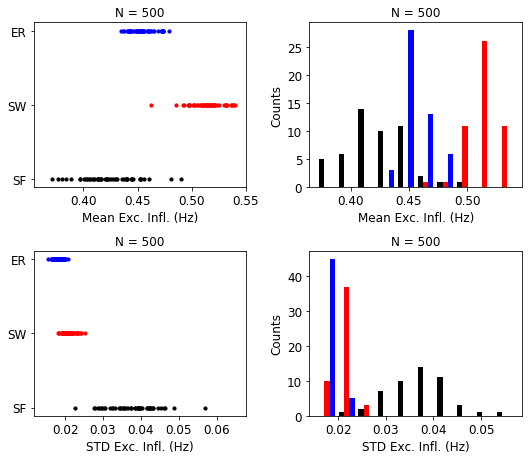

In [62]:
for n_ctr, n in enumerate(NS):
    
    xblt_ifl_means = xblt_ifl_means_all[n_ctr]
    xblt_ifl_stds = xblt_ifl_stds_all[n_ctr]

    colors = {'sf': 'k', 'sw': 'r', 'er': 'b'}
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6.5), tight_layout=True)

    # means
    axs[0, 0].scatter(xblt_ifl_means['sf'], np.repeat(0, N_TRIALS), s=10, c=colors['sf'])
    axs[0, 0].scatter(xblt_ifl_means['sw'], np.repeat(1, N_TRIALS), s=10, c=colors['sw'])
    axs[0, 0].scatter(xblt_ifl_means['er'], np.repeat(2, N_TRIALS), s=10, c=colors['er'])

    axs[0, 0].set_xlabel('Mean Exc. Infl. (Hz)')
    axs[0, 0].set_yticks([0, 1, 2])
    axs[0, 0].set_yticklabels(['SF', 'SW', 'ER'])

    axs[0, 1].hist(
        np.array([xblt_ifl_means[k] for k in ['sf', 'sw', 'er']]).T,
        color=[colors[k] for k in ['sf', 'sw', 'er']])

    axs[0, 1].set_xlabel('Mean Exc. Infl. (Hz)')
    axs[0, 1].set_ylabel('Counts')

    # stds
    axs[1, 0].scatter(xblt_ifl_stds['sf'], np.repeat(0, N_TRIALS), s=10, c=colors['sf'])
    axs[1, 0].scatter(xblt_ifl_stds['sw'], np.repeat(1, N_TRIALS), s=10, c=colors['sw'])
    axs[1, 0].scatter(xblt_ifl_stds['er'], np.repeat(2, N_TRIALS), s=10, c=colors['er'])

    axs[1, 0].set_xlabel('STD Exc. Infl. (Hz)')
    axs[1, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticklabels(['SF', 'SW', 'ER'])

    axs[1, 1].hist(
        np.array([xblt_ifl_stds[k] for k in ['sf', 'sw', 'er']]).T,
        color=[colors[k] for k in ['sf', 'sw', 'er']])

    axs[1, 1].set_xlabel('STD Exc. Infl. (Hz)')
    axs[1, 1].set_ylabel('Counts');

    for ax in axs.flatten():
        ax.set_title('N = {}'.format(n))
        set_font_size(ax, 12)

## Show distribution of maximum excitability influences

N = 100
Avg. Max (SF) = 1.6176589499048424
Avg. Max (SW) = 1.1962625748588636
Avg. Max (ER) = 1.0847319615133209
N = 200
Avg. Max (SF) = 1.1130169313956129
Avg. Max (SW) = 0.8227992679434796
Avg. Max (ER) = 0.7229917747983464
N = 500
Avg. Max (SF) = 0.5973172709559403
Avg. Max (SW) = 0.5813862179781178
Avg. Max (ER) = 0.5118057553422496


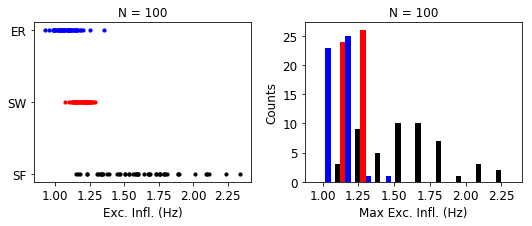

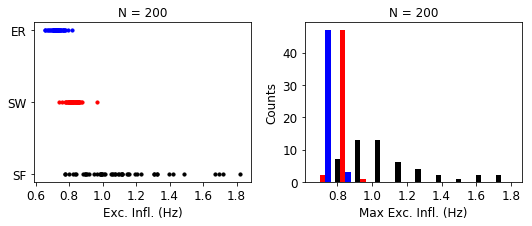

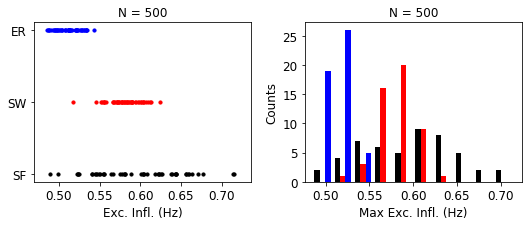

In [68]:
# compute max excitability influences for each N, ntwk struct, trial
xblt_ifl_maxs_all = []
for n_ctr in range(len(NS)):
    xblt_ifl_maxs = {
        k: np.array([np.max(xblt_ifl) for xblt_ifl in xblt_ifls_all[n_ctr][k]])
        for k in xblt_ifls_all[n_ctr]
    }
    xblt_ifl_maxs_all.append(xblt_ifl_maxs)
    
colors = {'sf': 'k', 'sw': 'r', 'er': 'b'}

for n_ctr, n in enumerate(NS):
    
    fig, axs = plt.subplots(1, 2, figsize=(7.5, 3.25), tight_layout=True)
    
    # scatter distributions
    ax = axs[0]
    
    xblt_ifl_maxs = xblt_ifl_maxs_all[n_ctr]
    
    ax.scatter(xblt_ifl_maxs['sf'], np.repeat(0, N_TRIALS), s=10, c=colors['sf'])
    ax.scatter(xblt_ifl_maxs['sw'], np.repeat(1, N_TRIALS), s=10, c=colors['sw'])
    ax.scatter(xblt_ifl_maxs['er'], np.repeat(2, N_TRIALS), s=10, c=colors['er'])
    
    ax.set_xlabel('Exc. Infl. (Hz)')
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['SF', 'SW', 'ER'])
    
    ax.set_title('N = {}'.format(n))
    
    # histograms
    ax = axs[1]
    
    ax.hist(
        np.array([xblt_ifl_maxs[k] for k in ['sf', 'sw', 'er']]).T,
        color=[colors[k] for k in ['sf', 'sw', 'er']])
    
    ax.set_xlabel('Max Exc. Infl. (Hz)')
    ax.set_ylabel('Counts')
    
    ax.set_title('N = {}'.format(n))
    
    for ax in axs.flatten():
        set_font_size(ax, 12)
    
# print mean max excitability influence
for n_ctr, n in enumerate(NS):
    
    print('N = {}'.format(n))
    
    xblt_ifl_maxs = xblt_ifl_maxs_all[n_ctr]
    
    print('Avg. Max (SF) = {}'.format(np.mean(xblt_ifl_maxs['sf'])))
    print('Avg. Max (SW) = {}'.format(np.mean(xblt_ifl_maxs['sw'])))
    print('Avg. Max (ER) = {}'.format(np.mean(xblt_ifl_maxs['er'])))

## Calculate stats

In [67]:
print('Means:')

for n_ctr, n in enumerate(NS):
    print('\nN = {}:\n'.format(n))
    
    xblt_ifl_means = xblt_ifl_means_all[n_ctr]
    xblt_ifl_stds = xblt_ifl_stds_all[n_ctr]

    # mean mean & std
    print('Mean SF mean = {0:.5f}'.format(np.mean(xblt_ifl_means['sf'])))
    print('Mean SF std = {0:.5f}'.format(np.mean(xblt_ifl_stds['sf'])))

    print('Mean SW mean = {0:.5f}'.format(np.mean(xblt_ifl_means['sw'])))
    print('Mean SW std = {0:.5f}'.format(np.mean(xblt_ifl_stds['sw'])))
    
    print('Mean ER mean = {0:.5f}'.format(np.mean(xblt_ifl_means['er'])))
    print('Mean ER std = {0:.5f}'.format(np.mean(xblt_ifl_stds['er'])))

    # p-values (t-test)
    for a, b in [('sf', 'sw'), ('sf', 'er'), ('sw', 'er')]:

        p_mu = stats.ttest_ind(xblt_ifl_means[a], xblt_ifl_means[b], equal_var=False)[1]
        p_std = stats.ttest_ind(xblt_ifl_stds[a], xblt_ifl_stds[b], equal_var=False)[1]

        print('P_MU({0}, {1}) = {2:.5f}'.format(a.upper(), b.upper(), p_mu))
        print('P_STD({0}, {1}) = {2:.5f}'.format(a.upper(), b.upper(), p_std))


print('\n\nMaxs:')

for n_ctr, n in enumerate(NS):
    print('\nN = {}:\n'.format(n))
    
    xblt_ifl_maxs = xblt_ifl_maxs_all[n_ctr]

    # mean max
    print('Mean SF max = {0:.5f}'.format(np.mean(xblt_ifl_maxs['sf'])))
    print('Mean SW max = {0:.5f}'.format(np.mean(xblt_ifl_maxs['sw'])))
    print('Mean ER max = {0:.5f}'.format(np.mean(xblt_ifl_maxs['er'])))

    # p-values (t-test)
    for a, b in [('sf', 'sw'), ('sf', 'er'), ('sw', 'er')]:

        p_mu = stats.ttest_ind(xblt_ifl_maxs[a], xblt_ifl_maxs[b], equal_var=False)[1]

        print('P_MU({0}, {1}) = {2:.5f}'.format(a.upper(), b.upper(), p_mu))

Means:

N = 100:

Mean SF mean = 0.78904
Mean SF std = 0.22984
Mean SW mean = 0.96455
Mean SW std = 0.08926
Mean ER mean = 0.82035
Mean ER std = 0.09347
P_MU(SF, SW) = 0.00000
P_STD(SF, SW) = 0.00000
P_MU(SF, ER) = 0.03970
P_STD(SF, ER) = 0.00000
P_MU(SW, ER) = 0.00000
P_STD(SW, ER) = 0.04872

N = 200:

Mean SF mean = 0.60454
Mean SF std = 0.11411
Mean SW mean = 0.69708
Mean SW std = 0.04533
Mean ER mean = 0.60714
Mean ER std = 0.03868
P_MU(SF, SW) = 0.00000
P_STD(SF, SW) = 0.00000
P_MU(SF, ER) = 0.79535
P_STD(SF, ER) = 0.00000
P_MU(SW, ER) = 0.00000
P_STD(SW, ER) = 0.00000

N = 500:

Mean SF mean = 0.42298
Mean SF std = 0.03776
Mean SW mean = 0.51413
Mean SW std = 0.02106
Mean ER mean = 0.45466
Mean ER std = 0.01825
P_MU(SF, SW) = 0.00000
P_STD(SF, SW) = 0.00000
P_MU(SF, ER) = 0.00000
P_STD(SF, ER) = 0.00000
P_MU(SW, ER) = 0.00000
P_STD(SW, ER) = 0.00000


Maxs:

N = 100:

Mean SF max = 1.61766
Mean SW max = 1.19626
Mean ER max = 1.08473
P_MU(SF, SW) = 0.00000
P_MU(SF, ER) = 0.00000
P

In [39]:
bak = {
    'xblt_ifls_all': deepcopy(xblt_ifls_all),
    'in_degs_all': deepcopy(in_degs_all),
    'out_degs_all': deepcopy(out_degs_all),
    'xblt_ifl_means_all': deepcopy(xblt_ifl_means_all),
    'xblt_ifl_stds_all': deepcopy(xblt_ifl_stds_all),
    'xblt_ifl_maxs_all': deepcopy(xblt_ifl_maxs_all),
    'frs_0_all': deepcopy(frs_0_all),
    'frs_1_all': deepcopy(frs_1_all),
}

In [40]:
from aux import save

save('data/_1A.npy', bak)

'data/_1A.npy'